<html>
 <head>
 </head>
 <body>
          <div class="alert alert-block alert-info" style="color:darkgreen;font-size:20px;text-align:center">
         <b>Regional Mapping Above-ground Biomass, Celebes island Indonesia 2022 </b>
     </div>
                    <p style="text-align:center;font-size:18px"> <b>Sentinel-2 using Google Earth Engine and Random Forest in Python 3.9</b></p>
               <p style="text-align:center"> February 2023 </p>
     <br/>
     <a id='content'></a>
     <p style="color:blue"> <b>Contents:</b> </p>
     <a href="#1."> 1. Region of Interest (ROI)</a><br/>
     <a href="#2."> 2. Mosaic of cloud-free Sentinel-2</a><br/>
     <a href="#3."> 3. Vegetation Indices</a><br/>
     <a href="#4."> 4. Machine learning: Random forest</a><br/>
     <a href="#5."> 5. Above-ground Biomass</a><br/>
     <a href="#6."> 6. Publish Map Online at Datapane.com</a><br/>
     <br/>
 </body>
</html>

<html>
 <head>
 </head>
 <body>
          <a id='1.'></a>
     <p style="color:blue;font-size:20px"> 1. Region of Interest (ROI)</p>
     <br/>
     <p> Some trivias of <b>Celebes</b> island:</p>
     <p> &emsp; &#x2022; the island is up to <b>186.000 km<sup>2</sup></b>, which makes the island as the <b>11<sup>st</sup> largest island in the world</b></p>
     <p> &emsp; &#x2022; it is entirely within administrative region of <b>Indonesia</b> with official name as <i>Sulawesi.</i></p>
     <p> &emsp; &#x2022; there is now 7 provinces in the island, one of those is Gorontalo province</p>
     <p> &emsp; &#x2022; the island has unique shape of <b>K</b> alpahbet, and has litle twin brother which aslo has similar K shape, named as 'Halmahera' island, located just 200 km on the northeast of Celebes island</p>
     <br/>
 </body>
</html>

<html>
 <head>
 </head>
 <body>
     <br/>
     <p> &#x2022; To save map as html file or publish it online (e.g., Datapane.com), you should import geemap package from geemap.foliumap library instead: <code>import geemap.foliumap as geemap</code></p>
     <br/>
 </body>
</html>

In [6]:
import ee
import geemap

ee.Initialize()

In [2]:
roi = geemap.shp_to_ee('/path/ROI.shp')

Map=geemap.Map(center=[-1.78,121], zoom=6.3)

In [ ]:
Map.addLayer(roi, {}, 'Celebes island', False)

Map

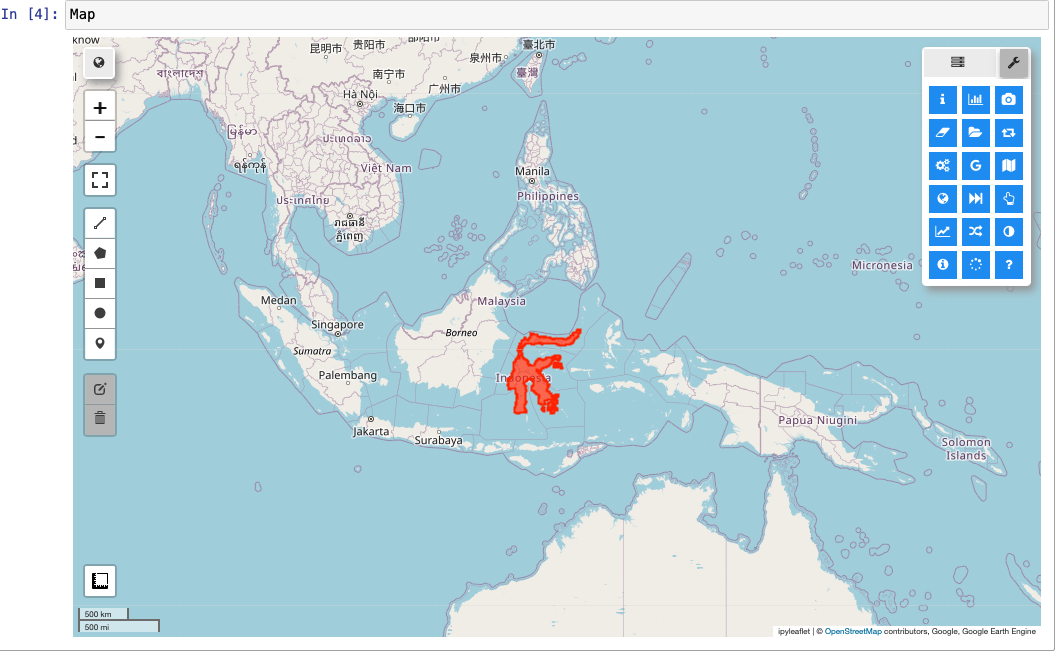

<html>
 <head>
 </head>
 <body>
          <a id='2.'></a>
     <p style="color:blue;font-size:20px"> 2. Mosaic of cloud-free Sentinel-2</p>
     <br/>
     <p> &emsp; &#x2022; python code for cloud masking is from <a href="https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless"  target="_blank">here</a></p>
     <p>&emsp; &#x2022; 2 image collections for Sentinel-2: <a href="https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR"  target="_blank">"COPERNICUS/S2_SR"</a> and <a href="https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED"  target="_blank">"COPERNICUS/S2_SR_HARMONIZED"</a> for data after <code>2022-01-25</code></p>
     <br/>
 </body>
</html>

In [3]:
def clipcol(image):
    clipimage = image.clip(roi)
    return clipimage

def get_s2_sr_cld_col(aoi, start_date, end_date, s2_col = 'COPERNICUS/S2_SR'):
    s2_sr_col = (ee.ImageCollection(s2_col)
        .filterBounds(aoi).map(clipcol)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))


def add_cloud_bands(img):
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    return img.addBands(ee.Image([cld_prb, is_cloud]))

def add_shadow_bands(img):
    not_water = img.select('SCL').neq(6)

    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

def add_cld_shdw_mask(img):
    img_cloud = add_cloud_bands(img)

    img_cloud_shadow = add_shadow_bands(img_cloud)

    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    return img_cloud_shadow.addBands(is_cld_shdw)

def apply_cld_shdw_mask(img):
    not_cld_shdw = img.select('cloudmask').Not()

    return img.select('B.*').updateMask(not_cld_shdw)

<html>
 <head>
 </head>
 <body>
     <br/>
     <p> &#x2022; we resample the map to 1x1 km<sup>2</sup></p>
     <p> &#x2022; getting cloud-free image is trial and error, so adjust these parameters of cloud filter, treshold, etc</p>
          <p> &#x2022; in this demonstration, we select the entire year of 2022</p>
     <br/>
 </body>
</html>

In [4]:
SR = 1000

CLOUD_FILTER = 30 
CLD_PRB_THRESH = 30 
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50

S_2022 = get_s2_sr_cld_col(roi, '2022-01-01', '2022-12-31', s2_col = 'COPERNICUS/S2_SR_HARMONIZED')

S_2022 = (S_2022.map(add_cld_shdw_mask)
                             .map(apply_cld_shdw_mask)
                             .median())

S_2022 = S_2022.reproject(crs='EPSG:4326', scale=SR)

In [5]:
my_param = {'bands': ['B4',  'B3',  'B2'], 'max':1500}
Map.addLayer(S_2022, my_param, "Free-cloud mosaic Sentinel 2")

In [5]:
Map

<html>
 <head>
 </head>
 <body>
     <br/>
     <p  style="color:red"> <b>NOTE !!!</b></p>
     <p>&#x2022; It is possible to compute large area in GEE (in the cloud). However, there is <b>limitation</b> when displaying the results on the map, or downloading the map as raster file to the local machine</p>
     <p>&#x2022; Due to memory limitation, I have to take 2 screenshots for the entire island and then mosaic it manually in Image editor</p>
     <p>&#x2022; Check this <a href="https://www.youtube.com/watch?v=Oi7YPY3j9q4"  target="_blank">reference</a> for multiprocessing with geemap package to download large image </p>
     <p>&#x2022; There are still few clouds in the results. Adjust the parameters accordingly</p>
     <br/>
 </body>
</html>

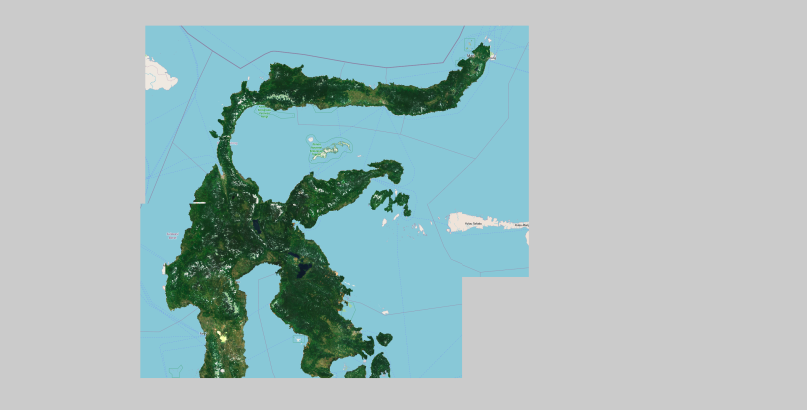

<html>
 <head>
 </head>
 <body>
          <a id='3.'></a>
     <p style="color:blue;font-size:20px"> 3. Vegetation Indices</p>
     <br/>
     <p> &#x2022; 4 Vegetation Indices: <code>NDVI</code>, <code>NDI45</code>, <code>SAVI</code>, and  <code>NDMI</code> </p>
     <p> &#x2022; the selection of these VIs is based on this <a href="https://www.youtube.com/watch?v=uKk3sM4WljQ"  target="_blank">reference</a> </p>
     <br/>
 </body>
</html>

In [7]:
def VI_stack(S2_mosaic):
    ndvi = S2_mosaic.select('B8').subtract(S2_mosaic.select('B4')).\
    divide(S2_mosaic.select('B8').add(S2_mosaic.select('B4'))).rename('NDVI')

    ndi45 = S2_mosaic.select('B5').subtract(S2_mosaic.select('B4')).\
    divide(S2_mosaic.select('B5').add(S2_mosaic.select('B4'))).rename('NDI45')

    savi = S2_mosaic.expression(
    '((1 + L) * (NIR - RED) / (NIR + RED + L))', {
      'NIR': S2_mosaic.select('B8'),
      'RED': S2_mosaic.select('B4'),
        'L':0.428 
    })

    savi = savi.rename('SAVI')

    ndmi = S2_mosaic.select('B8').subtract(S2_mosaic.select('B11')).\
    divide(S2_mosaic.select('B8').add(S2_mosaic.select('B11'))).rename('NDMI')

    VIs = ndvi.addBands(ndi45).addBands(savi).addBands(ndmi)
    
    return VIs

S_2022 = VI_stack(S_2022)

<html>
 <head>
 </head>
 <body>
          <a id='4.'></a>
     <p style="color:blue;font-size:20px"> 4. Machine Learning: Random forest</p>
     <br/>
     <p><b>Training data</b></p>
     <p> &#x2022; <a href="https://www.youtube.com/watch?v=uKk3sM4WljQ"  target="_blank">Reference</a> for AGB by machine learning with Random Forest and Regression model </p>
     <p>&#x2022; however, instead of using ESA Biomass Climate Change Initiative as reference data for training machine learning model, let use BIOMASS data from GEDI (L4A) which has better accuracy</p>
      <p> &#x2022; <a href="https://lpdaac.usgs.gov/resources/e-learning/spatial-querying-of-gedi-version-2-data-in-python/"  target="_blank">Reference: Spatial Querying of GEDI Version 2 Data in Python</a>  </p>
     <br/>
     <p><b>Classifier (Random Forest):</b></p>
     <p>&#x2022; <b>sklearn</b> library is needed for creating Machine Learning model</p>
     <p>&#x2022; GEE module has its own Random-forest classifier, but it seems only for <b>categorical</b> output such as land cover</p>
     <p>&#x2022; May be not proper for numerical output such as AGB</p>
     <p>&#x2022; user can perform accuracy check and hyperparameter tuning (e.g., RandomGridCV), nevertheless, this is just a demonstration</p>
     <br/>
 </body>
</html>

In [9]:
from geemap import ml
from sklearn import ensemble
import pandas as pd

AGB_VI = pd.read_csv('/Users/ismail/Documents/Machine_learning/Notebook/Github/data/gedi4agb_VI.csv')
AGB_VI = AGB_VI.drop(labels='geometry', axis=1)

DT = AGB_VI.loc[:,['agbd', 'NDVI', 'NDI45', 'SAVI', 'NDMI']]
DT.head()

,agbd,NDVI,NDI45,SAVI,NDMI
0,508.257782,0.843097,0.504482,1.203809,0.392474
1,479.744537,0.821438,0.455696,1.172883,0.367498
2,1329.603516,0.846280,0.488605,1.208347,0.347600
3,608.385132,0.846939,0.500000,1.209290,0.360633
4,445.777252,0.826039,0.483553,1.179444,0.367068


In [11]:
feature_names = ['NDMI', 'SAVI', 'NDVI', 'NDI45']
label = "agbd"

X = DT[feature_names]
y = DT[label]

In [12]:
n_trees = 10
rf = ensemble.RandomForestRegressor(n_trees).fit(X, y)
trees = ml.rf_to_strings(rf, feature_names, output_mode="REGRESSION")

ee_classifier = ml.strings_to_classifier(trees)

<html>
 <head>
 </head>
 <body>
          <a id='5.'></a>
     <p style="color:blue;font-size:20px"> 5. Above-ground Biomass</p>
     <p>&#x2022; you can extend the process by replicating the same process for other year, e.g., 2017, so you can calculate the AGB change over that year</p>
     <p></p>
     <br/>
 </body>
</html>

In [13]:
S_2022 = S_2022.select(['NDI45', 'NDMI', 'NDVI', 'SAVI']).classify(ee_classifier)

In [14]:
import geemap.colormaps as cm

palette = cm.get_palette('viridis_r', n_class=8)
my_param = {'bands': 'classification', 'min':0, 'max':500, 'palette': palette}

In [15]:
Map.addLayer(S_2022, my_param, "AGB 2022")
Map.add_colorbar(my_param, label="AGB (ton/ha)", orientation="vertical", layer_name="AGB")

In [ ]:
Map

<html>
 <head>
 </head>
 <body>
     <br/>
     <p  style="color:red"> <b>NOTE !!!</b></p>
     <p>&#x2022; Due to memory limitation for displaying the results on screen, we only display the results (calculated AGB) for Gorontalo province</p>
     <br/>
 </body>
</html>

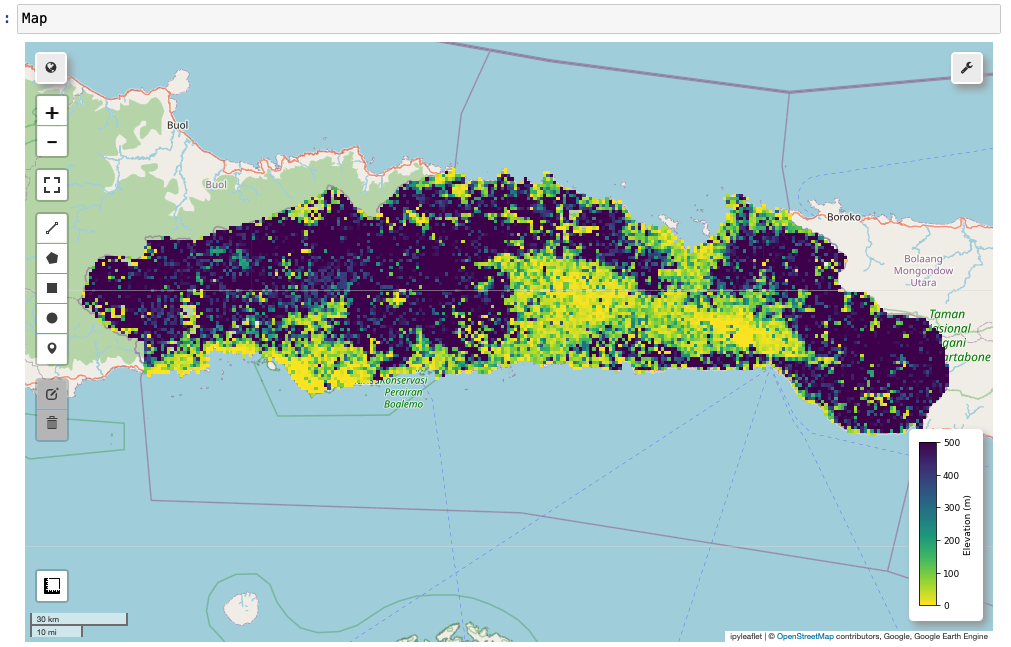

<html>
 <head>
 </head>
 <body>
          <a id='6.'></a>
     <p style="color:blue;font-size:20px"> 6. Publish map at Datapane.com</p>
     <p>&#x2022; <a href="https://docs.datapane.com/install-datapane/"  target="_blank">Reference</a> for Installation datapane library</p>
     <p>&#x2022; published map is available here at <a href="https://cloud.datapane.com/reports/dA9xjek/regional-biomass-mapping-in-indonesia-with-gee/"  target="_blank">Datapane.com</a></p>
     <br/>
 </body>
</html>

In [16]:
import datapane as dp

In [20]:
app = dp.App(dp.Plot(Map))
app.upload(name="regional biomass mapping in Indonesia with Gee")

Uploading report and associated data - *please wait...*

Report successfully uploaded - view and share at <a href='https://cloud.datapane.com/reports/dA9xjek/regional-biomass-mapping-in-indonesia-with-gee/' target='_blank'>here</a>.

In [18]:
Map.to_html(filename='/Users/ismail/Documents/Machine_learning/Notebook/Github/temp_AGB_map.html', 
            title='AGB by Sentinel-2 with Random forest')